In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
# from optimparallel import minimize_parallel

In [2]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

L = 3

Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 1-2*int(format(j, '0{}b'.format(L))[i])
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 1-2*int(format(j, '0{}b'.format(L))[i])
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

Sm = [Sp[i].T for i in range(L)]
Sx = [Sp[i]+Sm[i] for i in range(L)]
Sy = [-1j*Sz[i] @ Sx[i] for i in range(L)]
SxTot = sum(Sx)
SyTot = sum(Sy)

C:\Users\nfber\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [3]:
H = sum([Heis[i][(i+1)%L] for i in range(L-1)]) / 4
# H = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)])) / 4 # H plus Z_i Z_{i+2}

tf = 20
dt = tf / 300
Nt = int(tf / dt)
c = ['1', '1', '0'] #[str((1 + (-1)**(i+1)) // 2) for i in range(L)]
UnitVector = lambda c: np.eye(2**L)[c]
init = UnitVector(int(''.join(c), 2))

def ExactTimeEvolution(dt, nt, init):
    revos = [np.zeros(2**L) for i in range(nt+1)]
    revos[0] = init
    for i in range(nt):
        # scipy.sparse.linalg.expm_multiply
        revos[i+1] = expm(-1j * H * dt) @ revos[i]
    return revos

revos = ExactTimeEvolution(dt, Nt, init)

Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ (Sz[0]) @ revos[i] / 2)

C:\Users\nfber\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


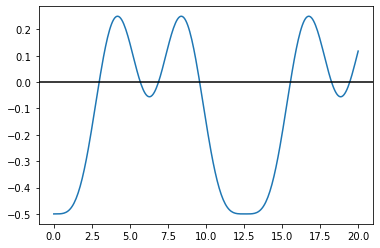

In [5]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.axhline(y=0, color='k')

In [4]:
def TrotterEvolve(dt, nt, init):
    if (L % 2 == 0):
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4) # 0 indexing, this is actually even indices
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L-1, 2)]) / 4) # range(1, L, 2) for periodic bdy conditions
        UTrotter = UOdd @ UEven
        # UZ = expm(-1j * dt * sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) / 2)
        # UTrotter = UEven @ UOdd @ UZ
    else:
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4)
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L, 2)]) / 4)
        # UBdy = expm(-1j * dt * Heis[L-1][0] / 4)
        UTrotter = UOdd @ UEven # UBdy @ UOdd @ UEven
    psi_trot = init
    for i in range(nt):
        psi_trot = UTrotter @ psi_trot
    return psi_trot

# def Ansatz(params, p):
#     psi_ansz = init
#     for i in range(p): # len(params) // L
#         for j in range(0, L, 2):
#             psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
#         for j in range(1, L, 2):
#             psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
#     return psi_ansz

# def Ansatz(params, p):
#     psi_ansz = init
#     for i in range(p): # len(params) // L
#         for j in range(0, L, 2):
#             # odd first, then even. Apply to left
#             psi_ansz = expm(-1j * params[(2*L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
#         for j in range(1, L, 2):
#             psi_ansz = expm(-1j * params[(2*L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
#         for j in range(L):
#             psi_ansz = expm(-1j * params[(2*L*i)+L+j] * diags(Heis[j][(j+2)%L].diagonal()).tocsc()) @ psi_ansz
#     return psi_ansz

def Loss(x, target, O):
    psi_ansz = Ansatz(x)
    Sz_ansz = np.conj(psi_ansz) @ (O) @ psi_ansz / 2
    Sz_ex = np.conj(target) @ (O) @ target / 2
    return abs(Sz_ansz - Sz_ex)

def Fidelity(x, target, p):
    psi_ansz = Ansatz(x, p)
    return 1 - abs(np.conj(target) @ psi_ansz)**2

In [30]:
ntrot = 2
dtrot = 1.0
tf = 20
shots = 2**10
op = Sz[0]

Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ op @ revos[i] / 2)

VTDStepList = pd.read_csv(f'VTD_results/shots_variation_loschmidt/VTD_results_{tf}_{L}_{ntrot}_{dtrot}_{shots}.csv', index_col=0)
VTDStepList = VTDStepList.applymap(lambda x: complex(x))
VTDSz = [np.array(np.conj(VTDStepList.iloc[i])) @ op @ np.array(VTDStepList.iloc[i]) / 2 for i in range(len(VTDStepList))]

TrotterFixStepList = [init]
ts = [i*ntrot*dtrot for i in range(int(np.ceil(tf / (ntrot * dtrot)))+1)]

for i in range(int(np.ceil(tf / (ntrot * dtrot)))):
    TrotterFixStepList.append(TrotterEvolve(dtrot, ntrot, TrotterFixStepList[i]))
TrotterFixStepSz = [np.conj(TrotterFixStepList[i]) @ op @ TrotterFixStepList[i] / 2 for i in range(len(TrotterFixStepList))]

BadTrotterFixStepList = [init]
for i in range(Nt):
    BadTrotterFixStepList.append(TrotterEvolve((i+1)*dt/(ntrot*3), ntrot*3, init))
BadTrotterFixStepSz = [np.conj(BadTrotterFixStepList[i]) @ op @ BadTrotterFixStepList[i] / 2 for i in range(len(BadTrotterFixStepList))]

C:\Users\nfber\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\nfber\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\langle \\psi | Z_0 | \\psi \\rangle$')

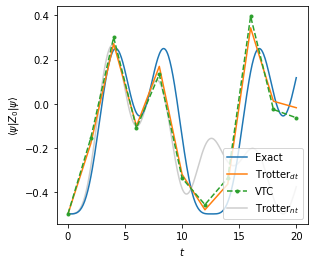

In [31]:
# plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1, 1, figsize=(4.5,4))

plt.plot([i*dt for i in range(len(revos))], Szt, label="Exact")
plt.plot(ts, TrotterFixStepSz, label="Trotter$_{dt}$")
plt.plot(VTDStepList.index, VTDSz, linestyle="--", marker=".", label="VTC")
plt.plot([i*dt for i in range(len(BadTrotterFixStepList[:]))], BadTrotterFixStepSz[:], label="Trotter$_{nt}$", c='#CDCDCD', zorder=0)
plt.legend(loc="lower right")
plt.xlabel('$t$')
plt.ylabel('$\langle \psi | Z_0 | \psi \\rangle$')

# plt.savefig('figures/VTC_expectation_6', dpi=300, transparent=False, bbox_inches='tight')


Text(0.5, 1.0, '1024 shots')

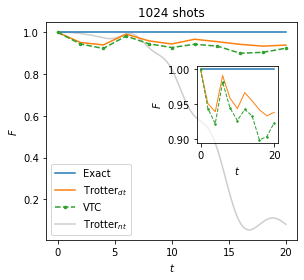

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(4.5,4))

ExFidelity = [abs(np.conj(revos[i]) @ revos[i])**2 for i in range(len(revos))]
BadTrotterFidelity = [abs(np.conj(revos[i]) @ BadTrotterFixStepList[i])**2 for i in range(len(BadTrotterFixStepList))]

revos_ = [expm(-1j * H * t) @ init for t in ts]

TrotterFidelity = [abs(np.conj(revos_[i]) @ TrotterFixStepList[i])**2 for i in range(len(TrotterFixStepList))]
VTDFidelity = [abs(np.conj(revos_[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]


ax2 = plt.axes([0.59, 0.46, 0.25, 0.27])
ax2.plot([i*dt for i in range(len(revos))], ExFidelity, label="Exact")
ax2.plot(ts, TrotterFidelity, label="Trotter", linewidth=1)
ax2.plot(VTDStepList.index, VTDFidelity, linestyle="--", marker='.', label="VTD", linewidth=1, markersize=3)
ax2.patch.set_alpha(0.7)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$F$')

ax.plot([i*dt for i in range(len(revos))], ExFidelity, label="Exact")
ax.plot(ts, TrotterFidelity, label="Trotter$_{dt}$")
ax.plot(VTDStepList.index, VTDFidelity, linestyle="--", marker='.', label="VTC", markersize=5)
ax.plot([i*dt for i in range(len(revos))], BadTrotterFidelity, label="Trotter$_{nt}$", c='#CDCDCD', zorder=0)
ax.legend(loc='lower left')
ax.set_xlabel('$t$')
ax.set_ylabel('$F$')

ax.set_title(f'{shots} shots')

# plt.savefig('figures/VTC_fidelity_6', dpi=300, transparent=False, bbox_inches='tight')
